In [1]:
import pandas as pd

In [2]:
reviews = pd.read_csv('../data/reviews.csv')

reviews.shape

(96512, 3)

In [3]:
reviews.head()

,Text,Summary,Score
0,Great taffy at a great price. There was a wid...,Great taffy,5
1,This taffy is so good. It is very soft and ch...,"Wonderful, tasty taffy",5
2,Right now I'm mostly just sprouting this so my...,Yay Barley,5
3,This is a very healthy dog food. Good for thei...,Healthy Dog Food,5
4,good flavor! these came securely packed... the...,fresh and greasy!,4


<AxesSubplot:title={'center':'Histogram of String Length'}, ylabel='Frequency'>

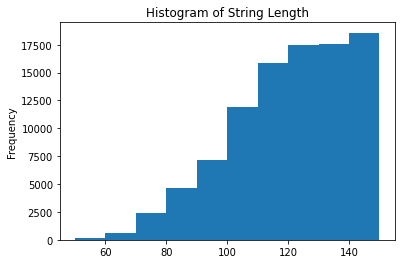

In [4]:
reviews['Text'].str.len().plot(kind='hist', title='Histogram of String Length')

In [5]:
reviews['Sentiment'] = reviews['Score'].map(lambda x: 'positive'  if x >=  4 else 'negative')

<AxesSubplot:>

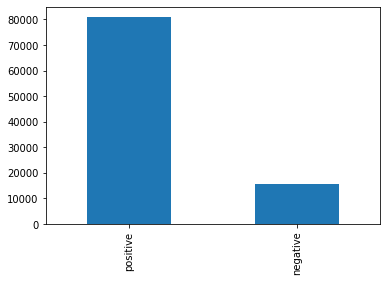

In [6]:
reviews['Sentiment'].value_counts().plot(kind='bar')

In [7]:
reviews_sample = reviews.groupby('Sentiment').sample(1000)

reviews_sample.shape

(2000, 4)

In [8]:
from transformers import GPT2Tokenizer

MODEL = 'distilgpt2'

tokenizer = GPT2Tokenizer.from_pretrained(MODEL)

tokenizer.pad_token = tokenizer.eos_token

#add two prompts, one for each task
SENTIMENT_PROMPT = 'Sentiment Task'
SUMMARIZE_PROMPT = 'Summarize Task'
SENTIMENT_TOKEN = '\nSentiment:'
SUMMARIZE_TOKEN = '\nSummarize:'

# Uncomment these lines to add the two tokens to the tokenizer as brand new tokens

# special_words_to_add={"additional_special_tokens": ['<sent>', '<summ>']}
# tokenizer.add_special_tokens(special_words_to_add)


INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


<AxesSubplot:>

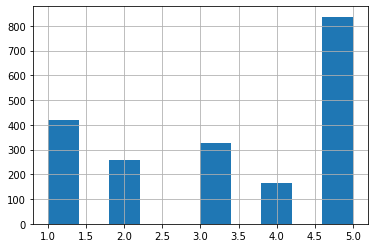

In [9]:
reviews_sample['Score'].hist()

In [10]:
reviews_sample['sentiment_text'] = f'{SENTIMENT_PROMPT}\nReview: ' + reviews_sample['Text'] + SENTIMENT_TOKEN +  ' ' + reviews_sample['Sentiment'].astype(str)

reviews_sample['summarize_text'] = f'{SUMMARIZE_PROMPT}\nReview: ' + reviews_sample['Text'] + SUMMARIZE_TOKEN +  ' ' + reviews_sample['Summary'].astype(str)


In [11]:
reviews_sample['sentiment_text'].head(2).tolist()

['Sentiment Task\nReview: This bar was a little to dry and too hard, not to mention on the bland tasting side too.\nSentiment: negative',
 'Sentiment Task\nReview: Country of origin is part of my decision making process.  I am posting this for others who may have similar concerns.\nSentiment: negative']

In [12]:
tokenizer.special_tokens_map

{'bos_token': '<|endoftext|>',
 'eos_token': '<|endoftext|>',
 'unk_token': '<|endoftext|>',
 'pad_token': '<|endoftext|>'}

In [13]:
reviews_sample['summarize_text'].head(2).tolist()

['Summarize Task\nReview: This bar was a little to dry and too hard, not to mention on the bland tasting side too.\nSummarize: Too dry',
 'Summarize Task\nReview: Country of origin is part of my decision making process.  I am posting this for others who may have similar concerns.\nSummarize: Tasty, but you should know they are produced in China']

In [14]:
# don't repeat utterances for sentiment or summarize
reviews_sample = reviews_sample.sample(frac=1)

mid_point = reviews_sample.shape[0]//2

training_examples = reviews_sample['summarize_text'].head(mid_point).tolist() + reviews_sample['sentiment_text'].tail(mid_point).tolist()


In [15]:
multi_task_df = pd.DataFrame({'text': training_examples})

multi_task_df.shape

(2000, 1)

In [16]:
print(multi_task_df['text'][1])

Summarize Task
Review: i ordered 2 boxes for my daughters bday =( when i opened it only few are in good conditions! i think like 6 of them... the rest are broken!!!
Summarize: dissapointed!!!!


In [17]:
print(multi_task_df['text'][10])

Summarize Task
Review: These cookies are my favories, hands down.  Move over, Nabisco!  You'll love these!
Summarize: Fabulous!


In [18]:
from datasets import Dataset
data = Dataset.from_pandas(multi_task_df)
data

Dataset({
    features: ['text'],
    num_rows: 2000
})

In [19]:
MAX_TOKENS = 200

# texts to numeric vectors of MAX_TOKENS
def tokenize_function(examples):
    # tokenizer created input_ids and attention_mask as output
    output = tokenizer(
        examples['text'],
        add_special_tokens=True,
        max_length=MAX_TOKENS,
        truncation=True,
        padding='max_length',
    )
    
    output['labels'] =  output["input_ids"]
    # -100 is a reserved value to ignore these tokens when calculating the loss
    output["labels"] = [[-100 if x == tokenizer.pad_token_id else x for x in y] for y in output["labels"]]
    return output

data = data.map(
    tokenize_function,
    batched=True,
)
print(data)


  0%|          | 0/2 [00:00<?, ?ba/s]

Dataset({
    features: ['attention_mask', 'input_ids', 'labels', 'text'],
    num_rows: 2000
})


In [20]:
data.set_format(type="python", columns=["input_ids", "attention_mask", "labels"])

data = data.train_test_split(test_size=0.20, shuffle=True, seed=0)
print(data)

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'text'],
        num_rows: 1600
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'text'],
        num_rows: 400
    })
})


In [21]:
tokenizer.decode(data['train'][0]['input_ids'])

'Sentiment Task\nReview: needed to be returned back to amazon. Was not sealed properly. Spilled all over box and then apartment. What a mess.\nSentiment: negative<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endo

In [22]:
tokenizer.decode([c for c  in data['train'][0]['labels'] if c != -100])

'Sentiment Task\nReview: needed to be returned back to amazon. Was not sealed properly. Spilled all over box and then apartment. What a mess.\nSentiment: negative'

In [23]:
len(data['train'][0]['input_ids'])

200

In [24]:
len(data['train'][0]['labels'])

200

In [25]:
len(data['train'][0]['attention_mask'])

200

In [26]:
from transformers import Trainer, TrainingArguments
from transformers import GPT2LMHeadModel

model = GPT2LMHeadModel.from_pretrained(MODEL)

# Update the model embeddings with the new vocabulary size IF we added new special tokens
# model.resize_token_embeddings(len(tokenizer))

model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )


In [30]:
training_args = TrainingArguments(
    output_dir="./gpt2_multitask", #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=2, # number of training epochs
    per_device_train_batch_size=64, # batch size for training
    per_device_eval_batch_size=64,  # batch size for evaluation
    warmup_steps=10,  # number of warmup steps for learning rate scheduler,
    weight_decay = 0.05,
    logging_steps=5,
    save_steps=10
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data['train'],
    eval_dataset=data['test'],
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [31]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 400
  Batch size = 64


{'eval_loss': 5.012487411499023,
 'eval_runtime': 260.9887,
 'eval_samples_per_second': 1.533,
 'eval_steps_per_second': 0.027}

In [32]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text.
***** Running training *****
  Num examples = 1600
  Num Epochs = 2
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 50


Step,Training Loss
5,4.961900
10,4.436600
15,3.926100
20,3.599800
25,3.321200
30,3.235500
35,3.113700
40,3.150300
45,3.112200
50,3.096400


Saving model checkpoint to ./gpt2_multitask/checkpoint-10
Configuration saved in ./gpt2_multitask/checkpoint-10/config.json
Model weights saved in ./gpt2_multitask/checkpoint-10/pytorch_model.bin
Saving model checkpoint to ./gpt2_multitask/checkpoint-20
Configuration saved in ./gpt2_multitask/checkpoint-20/config.json
Model weights saved in ./gpt2_multitask/checkpoint-20/pytorch_model.bin
Saving model checkpoint to ./gpt2_multitask/checkpoint-30
Configuration saved in ./gpt2_multitask/checkpoint-30/config.json
Model weights saved in ./gpt2_multitask/checkpoint-30/pytorch_model.bin
Saving model checkpoint to ./gpt2_multitask/checkpoint-40
Configuration saved in ./gpt2_multitask/checkpoint-40/config.json
Model weights saved in ./gpt2_multitask/checkpoint-40/pytorch_model.bin
Saving model checkpoint to ./gpt2_multitask/checkpoint-50
Configuration saved in ./gpt2_multitask/checkpoint-50/config.json
Model weights saved in ./gpt2_multitask/checkpoint-50/pytorch_model.bin


Training completed

TrainOutput(global_step=50, training_loss=3.5953738784790037, metrics={'train_runtime': 5101.7341, 'train_samples_per_second': 0.627, 'train_steps_per_second': 0.01, 'total_flos': 163310469120000.0, 'train_loss': 3.5953738784790037, 'epoch': 2.0})

In [33]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 400
  Batch size = 64


{'eval_loss': 3.0266082286834717,
 'eval_runtime': 140.2405,
 'eval_samples_per_second': 2.852,
 'eval_steps_per_second': 0.05,
 'epoch': 2.0}

In [34]:
trainer.save_model()

Saving model checkpoint to ./gpt2_multitask
Configuration saved in ./gpt2_multitask/config.json
Model weights saved in ./gpt2_multitask/pytorch_model.bin


In [35]:
from transformers import pipeline

loaded_model = GPT2LMHeadModel.from_pretrained('./gpt2_multitask')

generator = pipeline(
    'text-generation', model=loaded_model, tokenizer=tokenizer,
    config={'max_length': 200,  'do_sample': False}
)

loading configuration file ./gpt2_multitask/config.json
Model config GPT2Config {
  "_name_or_path": "distilgpt2",
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 1024,
  "resid_pdrop": 0.1,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "torch_dtype": "float32",
  "transformers_version": "4.10.0",


In [84]:
text_sample, score, summary = reviews_sample.sample(1)[['Text', 'Sentiment', 'Summary']].values[0]

print(text_sample)
print(score)
print(summary)

These crackers are delicious and filling. I have given up bread and these are a healthy substitute. I would recommend them to anyone.
positive
Fantastic Crackers


In [85]:
num_tokens = len(tokenizer(text_sample)['input_ids'])
num_tokens

27

In [86]:
sentiment_text_sample = f'{SENTIMENT_PROMPT}\nReview: {text_sample}{SENTIMENT_TOKEN}'
summarize_text_sample = f'{SUMMARIZE_PROMPT}\nReview: {text_sample}{SUMMARIZE_TOKEN}'

print(sentiment_text_sample)
print(summarize_text_sample)

Sentiment Task
Review: These crackers are delicious and filling. I have given up bread and these are a healthy substitute. I would recommend them to anyone.
Sentiment:
Summarize Task
Review: These crackers are delicious and filling. I have given up bread and these are a healthy substitute. I would recommend them to anyone.
Summarize:


In [87]:
encoded_input = tokenizer(sentiment_text_sample, return_tensors='pt')
    
print(tokenizer.decode(loaded_model.generate(
        input_ids=encoded_input['input_ids'],
        max_length=encoded_input['input_ids'].shape[1] + 1,
        temperature=0.1,
        top_k=2,
        do_sample=False
    )[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Sentiment Task
Review: These crackers are delicious and filling. I have given up bread and these are a healthy substitute. I would recommend them to anyone.
Sentiment: positive


In [88]:
encoded_input = tokenizer(summarize_text_sample, return_tensors='pt')
    
print(tokenizer.decode(loaded_model.generate(
        input_ids=encoded_input['input_ids'],
        max_length=len(encoded_input['input_ids']) + 10,
        temperature=0.5,
        beams=2,
        top_k=10,
        no_repeat_ngram_size=2,
    )[0], skip_special_tokens=False))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 39, but ``max_length`` is set to 11.This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.


Summarize Task
Review: These crackers are delicious and filling. I have given up bread and these are a healthy substitute. I would recommend them to anyone.
Summarize: Delicious


In [89]:
for generated_text in generator(sentiment_text_sample, num_return_sequences=5, max_length=num_tokens + 1):
    print(generated_text['generated_text'])
    

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 37, but ``max_length`` is set to 28.This can lead to unexpected behavior. You should consider increasing ``config.max_length`` or ``max_length``.


Sentiment Task
Review: These crackers are delicious and filling. I have given up bread and these are a healthy substitute. I would recommend them to anyone.
Sentiment: negative
Sentiment Task
Review: These crackers are delicious and filling. I have given up bread and these are a healthy substitute. I would recommend them to anyone.
Sentiment: positive
Sentiment Task
Review: These crackers are delicious and filling. I have given up bread and these are a healthy substitute. I would recommend them to anyone.
Sentiment: positive
Sentiment Task
Review: These crackers are delicious and filling. I have given up bread and these are a healthy substitute. I would recommend them to anyone.
Sentiment: negative
Sentiment Task
Review: These crackers are delicious and filling. I have given up bread and these are a healthy substitute. I would recommend them to anyone.
Sentiment: negative


In [93]:
for generated_text in generator(summarize_text_sample, num_return_sequences=5, max_length=num_tokens + 20):
    print(generated_text['generated_text'])
    

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Summarize Task
Review: These crackers are delicious and filling. I have given up bread and these are a healthy substitute. I would recommend them to anyone.
Summarize: tasty and filling. I have given up
Summarize Task
Review: These crackers are delicious and filling. I have given up bread and these are a healthy substitute. I would recommend them to anyone.
Summarize: Great flavor.
Summarize:
Summarize Task
Review: These crackers are delicious and filling. I have given up bread and these are a healthy substitute. I would recommend them to anyone.
Summarize: Smooth, refreshing and good tasting!

Summarize Task
Review: These crackers are delicious and filling. I have given up bread and these are a healthy substitute. I would recommend them to anyone.
Summarize:  I can buy a dozen varieties of
Summarize Task
Review: These crackers are delicious and filling. I have given up bread and these are a healthy substitute. I would recommend them to anyone.
Summarize: I find these sweet flavors eve